# Fine-tune Stable Diffusion using Dreambooth with LoRA

In this notebook, we show how to fine-tune a Stable Diffusion model using your own dataset but specifically utilizing the low rank adaptation technique, LoRA, which allows us to fine-tune the cross-attention layers without performing full fine-tuning. 

To do this, we'll utilize some Hugging Face libraries including the [Diffuser's Library](https://huggingface.co/docs/diffusers/index) and [PEFT Libraries](https://huggingface.co/docs/peft/index). 

Once again, we'll focus on fine-tuning using a few images of Molly dog as a puppy! 

# Setup

First, we'll perform some setup by installing dependencies.  Please restart the kernel after all dependencies have been installed.

In [21]:
!pip install transformers accelerate>=0.20.3 ftfy tensorboard Jinja2 huggingface_hub wandb kaggle git+https://github.com/huggingface/diffusers

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-kc6g5n89

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [22]:
! pip install -U accelerate
! pip install -U transformers


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.31.0', '0.21.0')

In [24]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

--2023-08-14 17:25:02--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58795 (57K) [text/plain]
Saving to: ‘train_dreambooth_lora.py.1’

train_dreambooth_lo 100%[===================>]  57.42K  --.-KB/s    in 0s      

2023-08-14 17:25:03 (121 MB/s) - ‘train_dreambooth_lora.py.1’ saved [58795/58795]



In [25]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/requirements.txt

--2023-08-14 17:25:06--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76 [text/plain]
Saving to: ‘requirements.txt.1’

requirements.txt.1  100%[===================>]      76  --.-KB/s    in 0s      

2023-08-14 17:25:07 (3.69 MB/s) - ‘requirements.txt.1’ saved [76/76]



In [26]:
!pip install -r requirements.txt
!pip install git+https://github.com/huggingface/peft

  Using cached evaluate-0.4.0-py3-none-any.whl (81 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.9 MB/s eta 0:00:0000:01
  Using cached xxhash-3.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
  Using cached aiohttp-3.8.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached multidict-6.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (114 kB)
  Using cached yarl-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (268 kB)
  Using cached frozenlist-1.4.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (225 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/huggingface/peft to /tmp/pip-req-build-0v634bdy
  Running command git clone --

In [73]:
!pwd

/root/dreambooth_lora


In [51]:
#!export INSTANCE_DIR='/home/sagemaker-user/dreambooth_lora/training_images'
#!export CLASS_DIR='/home/sagemaker-user/dreambooth_lora/base_class'

In [70]:
import shutil, os
dog_images = os.listdir("images-lora-molly")

In [68]:
!mkdir -p images-lora-molly-p
!mkdir -p images-lora-base-class

In [69]:
for filename in dog_images:
    shutil.copyfile(
         os.path.join("images-lora-molly-p",filename),
         os.path.join("images-lora-base-class",filename)
   )

In [89]:
%autosave 0

Autosave disabled


In [ ]:
instance_data_directory = '/home/sagemaker-user/generative-ai-on-aws/11_controlnet/images-lora-molly-p'

Next, we'll use a training script adapted from a Hugging Face example to fine-tune a Stable Diffusion model, specifically verson 1.5, using LoRA fine-tuning.  Also, to show variety in how you can choose to uilitize SageMaker as well as common libraries, we are showing training being locally performed on this SageMaker Studio notebook instance versus separate compute through spinning up training jobs.  This can be a good option for experimentation and you can easily [change the size of your SageMaker notebook](https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-run-and-manage-switch-instance-type.html) on the fly to support this type of experimentation.

We'll be using another Hugging Face library called [Accelerate](https://huggingface.co/docs/accelerate/index) which provides a variety of helpful libraries for running training and inference.

Note, in this case we are specifying the instance and class prompt directly in the configuration supplied instead of separately in the dataset_info.json as previously shown in the full fine-tuning notebook (03_dreambooth.ipynb).   

A few parameters to point out below include: 

  * **lora_r**: This parameter indicates the rank of the low rank matrices where a lower rank results in smaller matrices with fewer trainable parameters.
  * **lora_alpha**: This parameter notes the scaling factor to be used and controls how much importance you want to give to the new updated weight matrices when combining it with the original pretrained weights. 
  * **lr_scheduler**: This parameter controls how the learning rate changes during training. In the example below, we set it to 'constant' meaning that the learning rate will remain the same during training. 
  * **lr_warmup_steps**: This parameter specifies the number of warmup steps.

In [90]:
#https://huggingface.co/docs/peft/task_guides/dreambooth_lora#finetuning-dreambooth
!accelerate launch train_dreambooth_hf_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="images-lora-molly-p" \
  --class_data_dir="images-lora-base-class" \
  --output_dir=trained_model \
  --train_text_encoder \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="a photo of molly dog" \
  --class_prompt="a photo of a sks dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --use_lora \
  --lora_r 16 \
  --lora_alpha 27 \
  --lora_text_encoder_r 16 \
  --lora_text_encoder_alpha 17 \
  --learning_rate=1e-4 \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --max_train_steps=800

08/20/2023 20:00:20 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.
Loading pipeline components...:   0%|                     | 0/6 [00:00<?, ?it/s]Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'class_embeddings_concat', 'resnet_out_scale_factor', 'upcast_attention', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'encoder_hid_dim_type', 'mid_block_only_cross_attention', 'encoder_hid_dim', 'time_embedding_act_fn', 'time_embedding_type', 'num_attention_heads', 'num_class_embeds', 'addition_time_embed_dim', 'projection_class_embeddings_input_dim', 'use_linear_projection', 'transformer_layers_per_block', 'dual_cross_attention', 'conv_out_kernel', 'addition_embed_type', 'timestep_post_act', 'time_cond_proj_dim', 'resn

## Run inference against fine-tuned weights

Next, let's run inference against the fine-tune weights using the base model and the new fine-tuned LoRA weights.

In [91]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

In [92]:
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

Loading pipeline components...:  43%|████▎     | 3/7 [00:00<00:00,  5.48it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.20.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [93]:
def get_lora_sd_pipeline(
    ckpt_dir, base_model_name_or_path=None, dtype=torch.float16, device="cuda", adapter_name="molly"
):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    if os.path.exists(text_encoder_sub_dir) and base_model_name_or_path is None:
        config = LoraConfig.from_pretrained(text_encoder_sub_dir)
        base_model_name_or_path = config.base_model_name_or_path

    if base_model_name_or_path is None:
        raise ValueError("Please specify the base model name or path")

    pipe = StableDiffusionPipeline.from_pretrained(base_model_name_or_path, torch_dtype=dtype).to(device)
    pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)

    if os.path.exists(text_encoder_sub_dir):
        pipe.text_encoder = PeftModel.from_pretrained(
            pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name
        )

    if dtype in (torch.float16, torch.bfloat16):
        pipe.unet.half()
        pipe.text_encoder.half()

    pipe.to(device)
    return pipe

In [94]:
from pathlib import Path
from peft import PeftModel, LoraConfig
from diffusers import StableDiffusionPipeline

pipe = get_lora_sd_pipeline(Path("./trained_model"), adapter_name="molly")

Loading pipeline components...:  43%|████▎     | 3/7 [00:00<00:00,  6.42it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


In [96]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Now, let's prompt the model (in this case the base foundation model combined with the LoRA adapter weights) for a picture of Molly on the beach. 

100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


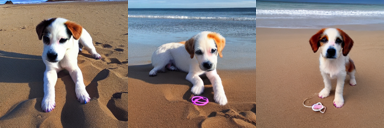

In [98]:
img_list = pipe(["Molly dog on a beach"]*3, num_inference_steps=50).images
image_grid([x.resize((128,128)) for x in img_list], 1,3)

# Congratulations! 

You fine-tuned Stable Diffusion models using a parameter efficient, light weight method that still allows for customization of the model based on your own dataset.  It's also suggested to review the size of the fine-tuned weights.  You'll notice the the fine-tuned weights are a fraction of the size of the full model allowing you to easily customize the model across a number of custom classes or subjects.  

In this case, we used our photos of Molly dog to fine-tune but feel free to try out your own examples.